## IMPORT STATEMENTS ##

In [23]:
from __future__ import print_function, division
from scipy.stats.stats import pearsonr, linregress
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import datetime
%matplotlib inline

## IMPORT DATA ##

In [3]:
taxi_dat = pd.read_csv("Taxi_Train.csv")
print(taxi_dat.count())
taxi_dat.head()

id            41898
start_time    41897
end_time      41897
fare          41897
number_pax    41897
start_lng     41897
start_lat     41897
end_lng       41897
end_lat       41897
start_taz     41897
end_taz       41897
dtype: int64


,id,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz
0,0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0
1,1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0
2,2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0
3,3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0
4,4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0


## DATA PRE-PROCESSING ##

In [4]:
#the id column of taxi_data is redundant, so I'll remove it here
taxi_data = taxi_dat.drop('id', 1)[:-1]
taxi_data.describe()
#taxi_data.head()

,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz
count,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000
mean,17.047906,1.100699,-122.415726,37.770983,-122.414716,37.769447,61.074612,80.488794
std,16.058616,0.422372,0.020074,0.045916,0.037718,0.052593,66.375489,135.680716
min,0.000000,0.000000,-122.515832,37.459648,-122.634420,37.225640,0.000000,0.000000
25%,8.450000,1.000000,-122.424645,37.771620,-122.429705,37.768903,12.000000,17.000000
50%,11.200000,1.000000,-122.412197,37.785703,-122.414028,37.785255,37.000000,43.000000
75%,16.700000,1.000000,-122.402870,37.792302,-122.403683,37.792668,88.000000,99.000000
max,281.250000,6.000000,-122.142390,37.940077,-121.353468,38.387638,1441.000000,1453.000000


#### Add Time Column ####

In [5]:
#Add a new column that converts the timestamp strings in the data to datetime.timedelta objects, which can be used 
#to find the time a ride has taken to complete.

def get_datetime(obj):
    month, obj = obj[:obj.index('/')], obj[obj.index('/')+1:]
    day, obj = obj[:obj.index('/')], obj[obj.index('/')+1:]
    year, obj = obj[:obj.index(' ')], obj[obj.index(' ')+1:]
    hour, obj = obj[:obj.index(':')], obj[obj.index(':')+1:]
    minute = obj
    return datetime.timedelta(int(year), int(month), int(day), int(hour), int(minute))

def get_difference(day1_string, day2_string):
    day1 = get_datetime(day1_string)
    day2 = get_datetime(day2_string)
    diff = (day2-day1).total_seconds()
    if diff<0:
        return int(3600+diff)/60
    else:
        return diff/60

start_times = np.array(taxi_data.get('start_time'))
end_times = np.array(taxi_data.get('end_time'))
ride_time = np.array([])

for i in np.arange(len(start_times)):
    day1_string = start_times.item(i)
    #print(day1_string)
    day2_string = end_times.item(i)
    #print(day2_string)
    diff = get_difference(day1_string, day2_string)
    #print(diff)
    ride_time = np.append(ride_time, diff)
    #print()

ride_time
    
taxi_with_time = taxi_data[:]
taxi_with_time['ride_time'] = pd.Series(ride_time, index=taxi_with_time.index)
taxi_with_time.describe()

C:\Users\aurum\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,ride_time
count,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000,41897.000000
mean,17.047906,1.100699,-122.415726,37.770983,-122.414716,37.769447,61.074612,80.488794,668.410936
std,16.058616,0.422372,0.020074,0.045916,0.037718,0.052593,66.375489,135.680716,436.404415
min,0.000000,0.000000,-122.515832,37.459648,-122.634420,37.225640,0.000000,0.000000,0.001000
25%,8.450000,1.000000,-122.424645,37.771620,-122.429705,37.768903,12.000000,17.000000,360.000000
50%,11.200000,1.000000,-122.412197,37.785703,-122.414028,37.785255,37.000000,43.000000,540.000000
75%,16.700000,1.000000,-122.402870,37.792302,-122.403683,37.792668,88.000000,99.000000,840.000000
max,281.250000,6.000000,-122.142390,37.940077,-121.353468,38.387638,1441.000000,1453.000000,3540.000000


#### Add Distance Column ####

In [6]:
#Add a new colunm that contains the sum of the distance between the two points' xs and the two points' ys.
#I chose not to use Pythagorean distances because the data is from SF, where streets are very gridded.
#This means a driver can't drive the Pythagorean distance, but likely has to drive in a series of perpendicular lines.
def distance_on_sphere(lon1, lon2, lat1, lat2):
    """ Computes distance (in miles) on the surface of the Earth
        between two locations
            lat1 : latitude of the first location
            lon1 : longitude of the first location
            lat2 : latitude of the second location
            lon2 : longitude of the second location
            Distance in miles ()
    """
    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0
    # phi = 90 - latitude converted to radians
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    # theta = longitude converted to radians
    theta1 = lon1*degrees_to_radians
    theta2 = lon2*degrees_to_radians     
    # We can compute spherical distance from spherical coordinates.
    cos1 = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1-theta2)+
           np.cos(phi1)*np.cos(phi2))
    arc1 = np.arccos(cos1)
    # Multiply arc by the radius of the earth to get length.
    return 3960.*arc1  # to get distance in miles

start_long = np.array(taxi_data.get('start_lng'))
end_long = np.array(taxi_data.get('end_lng'))
start_lat = np.array(taxi_data.get('start_lat'))
end_lat = np.array(taxi_data.get('end_lat'))
ride_dist = np.array([])

for i in np.arange(len(start_long)):
    ride_dist = np.append(ride_dist, distance_on_sphere(
        start_long.item(i), 
        end_long.item(i), 
        start_lat.item(i), 
        end_lat.item(i)
    ))

ride_dist

taxi_time_dist = taxi_with_time[:]
taxi_time_dist['ride_dist'] = pd.Series(ride_dist, index=taxi_time_dist.index)
taxi_time_dist.head()

C:\Users\aurum\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,ride_time,ride_dist
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,540.0,1.267380
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,480.0,1.857466
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,240.0,0.683803
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,780.0,1.982332
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,240.0,0.878686


#### Compare fares to distance and to time ####

16.55543413756209

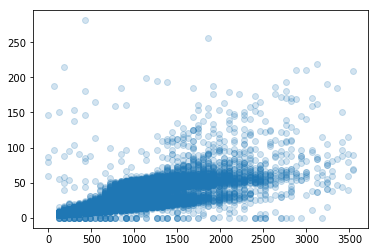

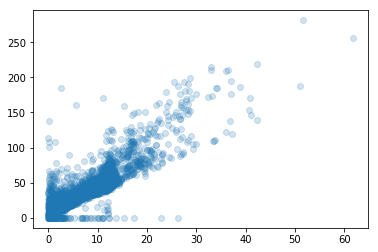

In [67]:
fares = np.array(taxi_time_dist.get(['fare']).iloc[:, 0])

plt.scatter(ride_time, fares, alpha=0.2)
plt.figure()
plt.scatter(ride_dist, fares, alpha=0.2)

normie_fares = fares[fares>5]
normie_fares = normie_fares[normie_fares<80]

sum(normie_fares)/len(normie_fares)

In [ ]:
pd.DataFrame(fares)

#### Visualize Plot of Ride Starts ####

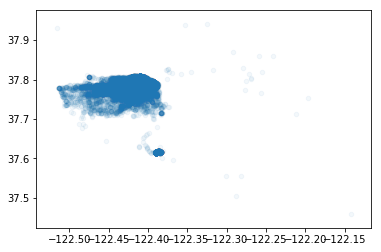

In [24]:
plt.scatter(
    taxi_time_dist.get(['start_lng']).iloc[:, 0], 
    taxi_time_dist.get(['start_lat']).iloc[:, 0], 
    s=20,  
    alpha=0.05
)

**WHY THE LITTLE ANOMALY AROUND (37.6, -122.38)??**

Let's find out what's there!

(37.60197266666667, 37.643135)

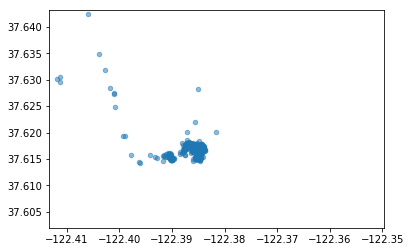

In [10]:
taxi_anomaly = taxi_time_dist[taxi_time_dist['start_lat'] < 37.65]

xmax = max(taxi_anomaly.get(['start_lng']).iloc[:, 0])
xmin = min(taxi_anomaly.get(['start_lng']).iloc[:, 0])
ymax = max(taxi_anomaly.get(['start_lat']).iloc[:, 0])
ymin = min(taxi_anomaly.get(['start_lat']).iloc[:, 0])
xdiff = xmax-xmin
ydiff = ymax-ymin

plt.scatter(
    taxi_anomaly.get(['start_lng']).iloc[:, 0], 
    taxi_anomaly.get(['start_lat']).iloc[:, 0], 
    s=20, 
    alpha=0.5
)
plt.xlim(xmin+0.04, xmin+xdiff/3)
plt.ylim(ymax-ydiff/3+0.02, ymax)

**TAKEAWAY:**
*The plot above shows the distribution of rides right around (37.615, -122.39), which is the coordinates of the SF Airport! That explains the anomaly we saw in the previous graph.*

In [61]:
taxi_airport = taxi_time_dist.iloc[:]
taxi_airport['start_airport'] = (taxi_airport['start_taz'] == 239.0).astype(int)
taxi_airport['end_airport'] = (taxi_airport['end_taz'] == 239.0).astype(int) 
taxi_airport.head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,ride_time,ride_dist,start_airport,end_airport
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,540.0,1.267380,0,0
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,480.0,1.857466,0,0
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,240.0,0.683803,0,0
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,780.0,1.982332,0,0
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,240.0,0.878686,0,0


In [ ]:
#TODO: Test the theory of surge pricing


## CROSS VALIDATION FOR DECISION TREE MODELS ##

In [62]:
## This function returns the RMSE of a model given predicted values and actual values
def rmse(predictions, actual):
    return np.sqrt(((predictions - actual) ** 2).mean())

#This function prints the predicted and actual fares of the ride, as well as the difference between the two and the MSE
def print_results(model_in, test_data, features, i):
    #set the features of the data
    X = test_data.get(features)
    y = test_data.get(['fare'])
    #test the model
    predicted_results = model_in.predict(X)
    #find the real results
    actual_results = np.array(y.iloc[:, 0])
    #print the predictions
    #print("\nThe predictions are: ", type(predicted_results), predicted_results)
    #print the real results
    #print("The actual fares are:", actual_results)
    #print the difference
    #print("The differences are: ", predicted_results - actual_results)
    #print the MSE
    model_rmse = rmse(predicted_results, actual_results)
    print("The RMSE of subset " + str(i) + " is:", model_rmse)
    return model_rmse
    
def k_fold_cross_validation(k, df, features, output_col, model_type):    
    #Prepare for k-fold cross-validation
    df_len = df.shape[0]
    #df = shuffle(df)
    models = np.array([])
    rmse = np.array([])
    for i in range(k):
        #find the indices to take
        lower_bound = i*df_len/k
        upper_bound = (i+1)*df_len/k
        val_range = np.arange(lower_bound, upper_bound) # 1/kth of the data, used for testing
        train_range = np.concatenate((np.arange(0, lower_bound), 
                                      np.arange(upper_bound, df_len))) #(k-1)/kth of the data, used for training
        #define testing and training samples for fold i
        val = df.take(val_range)
        train = df.take(train_range)
        #set the features of the data
        X = train.get(features)
        y = train.get(output_col)
        # Define model. Specify a number for random_state to ensure same results each run
        model_alpha = model_type
        # Fit model
        model_alpha.fit(X, y)
        #print the results of the model
        model_rmse = print_results(model_alpha, val, features, i)
        models = np.append(models, model_alpha)
        rmse = np.append(rmse, model_rmse)
    return models, rmse

def try_decision_tree_model(df, features):
    df_trainer = df.take(np.arange(round(0.85*df.shape[0])))
    df_test = df.take(np.arange(round(0.85*df.shape[0]), df.shape[0]))
    decision_tree_results = k_fold_cross_validation(10, df_trainer, features, ['fare'], DecisionTreeRegressor(random_state=1))
    print("\nAverage RMSE of ", features, "is")
    print(sum(decision_tree_results[1])/len(decision_tree_results[1]))


try_decision_tree_model(taxi_airport, ['ride_time'])
try_decision_tree_model(taxi_airport, ['ride_dist'])
try_decision_tree_model(taxi_airport, ['ride_time', 'ride_dist'])
try_decision_tree_model(taxi_airport, ['ride_time', 'ride_dist', 'start_airport'])
try_decision_tree_model(taxi_airport, ['ride_time', 'ride_dist', 'end_airport'])


#linear_tree_results = k_fold_cross_validation(10, taxi_time_dist, ['ride_time', 'ride_dist'], ['fare'], LinearRegression())



The RMSE of subset 0 is: 5.292368084160147
The RMSE of subset 1 is: 5.54003575637561
The RMSE of subset 2 is: 6.275280470365594
The RMSE of subset 3 is: 6.922071979435754
The RMSE of subset 4 is: 6.701937483319285
The RMSE of subset 5 is: 5.632100739962579
The RMSE of subset 6 is: 6.67425772747815
The RMSE of subset 7 is: 5.045971508753619
The RMSE of subset 8 is: 6.575778812037398
The RMSE of subset 9 is: 6.049053886328673

Average RMSE of  ['ride_time', 'ride_dist'] is
6.070885644821681
The RMSE of subset 0 is: 7.607565734870208
The RMSE of subset 1 is: 7.593801324439926
The RMSE of subset 2 is: 10.520918916447071
The RMSE of subset 3 is: 10.64403111970552
The RMSE of subset 4 is: 10.399221463678218
The RMSE of subset 5 is: 9.469180690480867
The RMSE of subset 6 is: 9.555384103769317
The RMSE of subset 7 is: 8.936952848117086
The RMSE of subset 8 is: 9.69213925562027
The RMSE of subset 9 is: 9.814262982949094

Average RMSE of  ['ride_time'] is
9.423345844007757
The RMSE of subset 0 i

In [ ]:
#TODO: Use a Neural Network, a RandomForest, a Support Vector Machine

## ERROR DETECTION AND OUTLIER HANDLING ##

In [19]:
taxi_time_dist[taxi_time_dist['fare']>150].iloc[:, [0, 2, 3, 8, 9, 10, 11]]

,start_time,fare,number_pax,start_taz,end_taz,ride_time,ride_dist
509,9/1/12 15:27,166.10,1.0,239.0,405.0,2820.000000,27.911081
7407,9/3/12 19:26,154.20,1.0,69.0,1265.0,300.001000,40.607193
7860,9/3/12 10:17,150.73,1.0,239.0,751.0,2280.000000,23.893824
9144,9/3/12 17:40,210.00,1.0,239.0,563.0,3000.000000,36.381625
9602,9/3/12 20:55,281.25,1.0,239.0,1252.0,420.000000,51.586500
10653,9/5/12 1:53,152.10,1.0,24.0,354.0,2400.000000,28.759618
10789,9/4/12 12:08,159.70,1.0,239.0,340.0,780.001000,15.301134
10815,9/3/12 17:28,163.20,1.0,239.0,1154.0,2040.000000,22.408912
12712,9/4/12 17:56,157.40,1.0,239.0,416.0,2340.000000,26.850665
13540,9/5/12 23:30,161.16,1.0,239.0,416.0,1740.000000,26.838043
